# Ensemble SWIFT model runs

## About this document

This document was generated from an R markdown file on `r as.character(Sys.time())`.

## Elaboration

In [1]:
import pandas as pd
import numpy as np
import swift2
from swift2.simulation import get_subarea_ids
from swift2.utils import mk_full_data_id, paste0
import xarray as xr

In [2]:
import swift2.doc_helper as std
import swift2.parameteriser as sp

In [3]:
from swift2.const import CATCHMENT_FLOWRATE_VARID

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

Let's create a test catchment with a few subareas 

In [6]:
runoff_model='GR4J'

In [7]:
node_ids=paste0('n', [i+1 for i in range(6)])
link_ids = paste0('lnk', [i+1 for i in range(5)])
node_names = paste0(node_ids, '_name')
link_names = paste0(link_ids, '_name')
from_node = paste0('n', [2,5,4,3,1])
to_node = paste0('n', [6,2,2,4,4])
areas_km2 = np.array([1.2, 2.3, 4.4, 2.2, 1.5])

In [8]:
simulation = std.create_catchment(node_ids, node_names, link_ids, link_names, from_node, to_node, runoff_model, areas_km2)

the package `uchronia` includes facilities to access time series from a "library", akin to what you would do to manage books.

In [9]:
import uchronia.sample_data as usd

In [10]:
import os
os.environ['SWIFT_TEST_DIR'] = os.path.expanduser('~/data/documentation') 

In [11]:
doc_data_path = usd.sample_data_dir()
data_path = os.path.join(doc_data_path, 'UpperMurray')
data_path

'/home/per202/data/documentation/UpperMurray'

In [12]:
data_library = usd.sample_time_series_library('upper murray')

In [13]:
data_library

CFFI pointer handle to a native pointer of type id "ENSEMBLE_DATA_SET_PTR"

In [14]:
from uchronia.data_set import get_dataset_ids, datasets_summaries

data_ids = get_dataset_ids(data_library)

In [15]:
datasets_summaries(data_library)

['variable name: pet_der, identifier: 1, start: 1989-12-31T00:00:00, end: 2012-12-30T00:00:00, time length: 8401, time step: daily',
 'variable name: pet_der, identifier: 1, start: 1988-12-31T00:00:00, end: 2012-12-30T00:00:00, time length: 8766, time step: daily',
 'variable name: rain_der, identifier: 1, start: 1989-12-31T13:00:00, end: 2012-10-31T12:00:00, time length: 200160, time step: hourly',
 'variable name: rain_fcast_ens, identifier: 1, index: 0, start: 2010-08-01T21:00:00, end: 2010-08-06T21:00:00, time length: 5, time step: <not yet supported>']

The sample catchment structure is obviously not the real "Upper Murray". For the sake of a didactic example, let's set the same inputs across all the subareas.

In [16]:
precip_ids = mk_full_data_id( 'subarea', get_subarea_ids(simulation), 'P')
evapIds = mk_full_data_id( 'subarea', get_subarea_ids(simulation), 'E')
precip_ids, evapIds

(['subarea.lnk1.P',
  'subarea.lnk2.P',
  'subarea.lnk3.P',
  'subarea.lnk4.P',
  'subarea.lnk5.P'],
 ['subarea.lnk1.E',
  'subarea.lnk2.E',
  'subarea.lnk3.E',
  'subarea.lnk4.E',
  'subarea.lnk5.E'])

In [17]:
def _rep(x): return np.repeat(x, len(precip_ids))
simulation.play_inputs(data_library, precip_ids, _rep('rain_obs'), _rep(''))
simulation.play_inputs(data_library, evapIds, _rep('pet_obs'), _rep('daily_to_hourly'))
# And the flow rate we will record
outflowId = CATCHMENT_FLOWRATE_VARID

Given the information from the input data, let's define a suitable simulation time span. NOTE and TODO: hourly information may not have been shown above yet.

In [18]:
from cinterop.timeseries import as_timestamp
 
s = as_timestamp('2007-01-01')
e = as_timestamp('2010-08-01 20')
sHot = as_timestamp('2010-08-01 21')
eHot = as_timestamp('2010-08-05 21')

First, before demonstrating ensemble forecasting simulations, let's demonstrate how we can get a snapshot of the model states at a point in time and restore it later on, hot-starting further simulation.

In [19]:
simulation.set_simulation_span(start=s, end=eHot)
simulation.record_state(outflowId)
simulation.exec_simulation()
baseline = simulation.get_recorded(outflowId)

In [20]:
baseline = baseline.squeeze(drop=True).sel(time = slice(sHot, eHot))

In [21]:
simulation.set_simulation_span(start=s, end=e)
simulation.exec_simulation()
snapshot = simulation.snapshot_state()

We can execute a simulation over the new time span, but requesting model states to NOT be reset. If we compare with a simulation where, as per default, the states are reset before the first time step, we notice a difference:

In [22]:
simulation.set_simulation_span(start=sHot, end=eHot)
simulation.exec_simulation(reset_initial_states = False)
noReset = simulation.get_recorded(outflowId)
simulation.exec_simulation(reset_initial_states = True)
withReset = simulation.get_recorded(outflowId)

In [23]:
noReset = noReset.squeeze(drop=True)

x = xr.concat([noReset,withReset], dim=pd.Index(['no reset','reset'], name='scenario')).squeeze(drop=True)

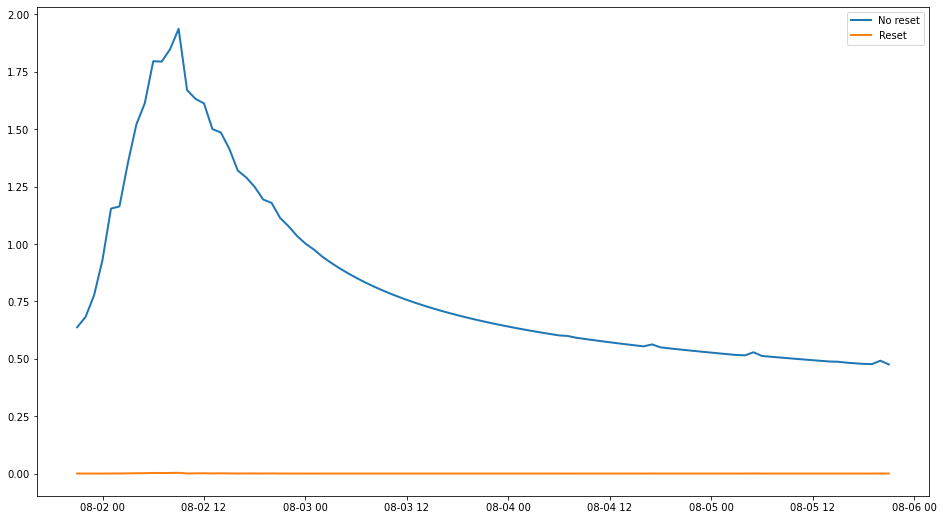

In [24]:
#zoo::plot.zoo(x, plot.type='single', col=c('blue','red'), ylab="Outflow m3/s", main="Outflows with/without state resets")
# TODO: see whether waa figures are appropriate
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(x.time.values, x.sel(scenario='no reset'), linewidth=2, label='No reset')
ax.plot(x.time.values, x.sel(scenario='reset'), linewidth=2, label='Reset')
ax.legend()
plt.show()

Now let'd ready the simulation to do ensemble forecasts. We define a list `inputMap` such that keys are the names of ensemble forecast time series found in `data_library` and the values is one or more of the model properties found in the simulation. In this instance we use the same series for all model precipitation inputs in `precip_ids` 

In [25]:
simulation.reset_model_states()
simulation.set_states(snapshot)

In [26]:
inputMap = {'rain_fcast_ens':precip_ids}

In [27]:
ems = simulation.create_ensemble_forecast_simulation(data_library, start=sHot, end=eHot, input_map=inputMap, lead_time=(24*2+23), ensemble_size=100, n_time_steps_between_forecasts=24)

In [28]:
ems.get_simulation_span()

{'start': datetime.datetime(2010, 8, 1, 21, 0),
 'end': datetime.datetime(2010, 8, 4, 21, 0),
 'time step': 'hourly'}

In [29]:
import swift2.play_record as spr
ems.record_state(outflowId)
ems.exec_simulation()
forecasts = ems.get_recorded_ensemble_forecast(outflowId)

In [30]:
flow_forecasts = forecasts.get_item(1)

In [31]:
flow_forecasts

<xarray.DataArray (ensemble: 100, time: 71)>
array([[0.8898914 , 0.97225084, 1.05916427, ..., 0.76254716, 0.6787237 ,
        0.6702664 ],
       [0.63547795, 0.62744525, 0.61985413, ..., 0.47899561, 0.48934704,
        0.49825249],
       [0.62397353, 0.61255692, 0.60179053, ..., 0.41359509, 0.4271383 ,
        0.43487164],
       ...,
       [0.61988133, 0.6072754 , 0.59540094, ..., 0.48367713, 0.47991112,
        0.47624805],
       [0.61967395, 0.60698496, 0.59505003, ..., 0.46636062, 0.46183589,
        0.45746333],
       [0.61967228, 0.60698117, 0.59504373, ..., 0.34924574, 0.34735597,
        0.34549876]])
Coordinates:
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * time      (time) datetime64[ns] 2010-08-01T22:00:00 ... 2010-08-04T20:00:00

In [32]:
q = flow_forecasts.quantile([0.05, .25, .5, .75, 0.95], 'ensemble')

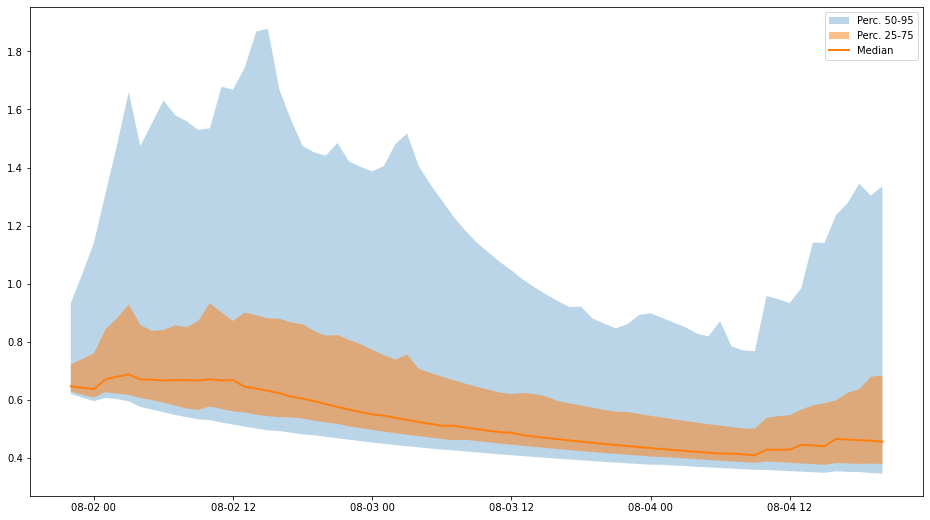

In [33]:
fig, ax = plt.subplots(figsize=(16,9))
ax.fill_between(q.time.values, q.sel(quantile=0.05), q.sel(quantile=0.95), alpha=0.3, label='Perc. 50-95')
ax.fill_between(q.time.values, q.sel(quantile=0.25), q.sel(quantile=.75), alpha=0.5, label='Perc. 25-75')
ax._get_lines.get_next_color()  # Hack to get different line
ax.plot(q.time.values, q.sel(quantile=.5), linewidth=2, label='Median')
ax.legend()
plt.show()